In [170]:
import pandas as pd
import numpy as np
import random
import scipy
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)


<a id='ab'></a>
##  A/B тестирование

A/B-тестирование (англ. A/B testing, Split testing) — метод маркетингового исследования, суть которого заключается в том, что контрольная группа элементов сравнивается с набором тестовых групп, в которых один или несколько показателей были изменены, для того, чтобы выяснить, какие из изменений улучшают целевой показатель и улучшают ли.

Типичное применение в веб-дизайне — исследование влияния цветовой схемы, расположения и размера элементов интерфейса на конверсию сайта.

Конверсия (Conversion Rate) в интернет-маркетинге — это отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия (покупку, регистрацию, подписку, посещение определённой страницы сайта, переход по рекламной ссылке), к общему числу посетителей сайта, выраженное в процентах. 



В теории принципы A/B тестирования невероятно просты:

- Выдвигаем предположение о том, что какое-то изменение (например, персонализация главной страницы) увеличит конверсию интернет-магазина.

- Создаем альтернативную версию сайта «Б» — копию исходной версии «А» с изменениями, от которых мы ждем роста эффективности сайта.

- Всех посетителей сайта случайным образом делим на две равные группы: одной группе показываем исходный вариант (контрольная группа) , второй группе (тестовой) — альтернативный. Одновременно измеряем конверсию для обеих версий сайта.

- Определяем статистически достоверно победивший вариант.

Мы будем анализировать результаты A/B тестирования двух версий дизайна кнопки сайта интернет-магазина. 

Целевым действием считаем клик по этой кнопке. 

Первые три этапа А/В тестирования за нас провели, результаты предоставили в виде файла ab_dataset.csv. Нам осталось выполнить четвертый пункт.

### Задание 

Провести аналогичные исследования но для чека покупок клиентов (колонки `revenue`)  
в интернет магазине есть 2-ва типа продуктов:
* 100 руб.
* 250 руб.

ну и конечно клиент может ничего не купить  
провести исследование изменился ли средний чек

 <a id='eda'></a>
### Первичный анализ данных

Прочитаем данные из файла `ab_datas.csv`. Сохраним их в датафрейм `df`. 

Прочитаем данные и посмотрим на первые 5 строк:

In [171]:
df = pd.read_csv('ab_datas.csv')

df.head()

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250


Посмотрим, сколько посетителей заходио на сайт (количество строк в нашем датафрейме)

In [172]:
#количество посетителей всего

n_rows = df.shape[0]
print("Число строк: {}".format(n_rows))

Число строк: 294478


Сколько уникальных пользователей (уникальных `user_id`) в датасете?

In [173]:
user_total = df.nunique()['user_id']
print("Число уникальных пользователей : {}".format(user_total))

Число уникальных пользователей : 290584


Посетителей из контрольной `control` группы должны были направлять на страницу в старом дизайне  `old_page` , пользователей из тестовой группы `treatment` - на страницу в новом дизайне `new_page`. Проверим, были ли ошибки при направлении.

In [174]:
mismatch_1 = df.query("group == 'treatment' and landing_page == 'old_page'")
print("Из тестовой группы неверно направлены {}".format(len(mismatch_1)) + " пользователей")

mismatch_2 = df.query("group == 'control' and landing_page == 'new_page'")
print("Из контрольной группы неверно направлены  {}".format(len(mismatch_2)) + " пользователей")


Из тестовой группы неверно направлены 1965 пользователей
Из контрольной группы неверно направлены  1928 пользователей


Выясним, есть ли в данных пропуски.

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
 5   revenue       294478 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 13.5+ MB


Из сообщений следует, что пропущенных значений нет.

Конверсия по всем посетителям

In [176]:
p_all=df['converted'].mean()
print("Конверсия по всем посетителям: {} %".format(p_all*100))

Конверсия по всем посетителям: 11.96591935560551 %


In [177]:
# можно и так:
sum(df['converted'].values)/n_rows

0.11965919355605512

Давайте посмотрим на описательную статистику нашего датасета (воспользуемся функцией  `describe`) и постараемся получить ответы на следующие вопросы:

- Какова вероятность клика для посетителей из контрольной группы (старый дизайн)?

- Какова вероятность клика для посетителей из тестовой группы (новый дизайн кнопки)?

- Каково соотношение размеров тестовой и контрольный групп? Какова вероятность, что очередной посетитель будет направлен на версию со старым дизайном? С новым дизайном?

In [178]:
df_grp = df.groupby('group')
df_grp.describe()

user_id                                                   \
              count           mean           std       min       25%   
group                                                                  
control    147202.0  788123.098035  91278.896888  630002.0  709287.0   
treatment  147276.0  787825.226283  91142.800641  630000.0  708729.5   

                                         converted            ...            \
                50%        75%       max     count      mean  ...  75%  max   
group                                                         ...             
control    788053.5  867155.50  945998.0  147202.0  0.120399  ...  0.0  1.0   
treatment  787837.5  866693.75  945999.0  147276.0  0.118920  ...  0.0  1.0   

            revenue                                                         
              count        mean         std  min  25%    50%    75%    max  
group                                                                       
control    147202.0   87.431896  102.424926  0.0  0.0    0.0  250.0  250.0  
treatment  147276.0  116.496238  102.732069  0.0  0.0  100.0  250.0  250.0  

[2 rows x 24 columns]

Ответы на остальные вопросы можно найти, например, так:

In [179]:
#объем тестовой группы
n_rows_treat = len(df[df['group'] == 'treatment'])

#объем контрольной группы
n_rows_contr = n_rows-n_rows_treat

print("Соотношение размеров тестовой и контрольной групп: {}".format(n_rows_treat/n_rows_contr))

print("Вероятность, что новый пользователь будет направлен на версию со старым дизайном: {}".format(n_rows_treat/n_rows))
print("Вероятность, что новый пользователь будет направлен на версию с новым дизайном: {}".format(n_rows_contr/n_rows))


Соотношение размеров тестовой и контрольной групп: 1.0005027105609978
Вероятность, что новый пользователь будет направлен на версию со старым дизайном: 0.5001256460584492
Вероятность, что новый пользователь будет направлен на версию с новым дизайном: 0.49987435394155083


**Задание **

А теперь ответьте на главный вопрос данного этапа:  выявил ли предварительный анализ, что дизайн кнопки влияет на конверсию и если да, то как именно?


In [180]:
#Посмотрим конверсию контрольной и тестовой групп
conv_treat = df[df['group'] == 'treatment']['converted'].mean()
conv_ctrl = df[df['group'] == 'control']['converted'].mean()

print(f'Конверсия пользователей из тестовой группы: {conv_treat}, \n' \
     f'Конверсия пользователей из контрольной группы: {conv_ctrl}')

Конверсия пользователей из тестовой группы: 0.11891957956489856, 
Конверсия пользователей из контрольной группы: 0.12039917935897611


**ВЫВОД.** По предварительному анализу можно сделать вывод, что дизайн кнопки негативно повлиял на конверсию, она стала ниже

<a id='si1'></a>
#### Формулировка рабочей гипотезы

Рабочая гипотеза в нашем случае может быть сформулирована, например, так: "Конверсия сайта со старым дизайном не меньше, чем с новым"

<a id='si2'></a>
#### Формальное описание нулевой и альтернативной гипотез

$H_{0}$ : $\theta_{new}$ <= $\theta_{old}$ 

$H_{1}$ : $\theta_{new}$ > $\theta_{old}$ 

<a id='si1'></a>
#### Выбор подходящего статистического теста (статистического критерия)

Истинные значения $\theta_{new}$ и $\theta_{old}$ мы найти не можем, но мы можем их сравнить. В этом помогут те самые две теоремы.






На основании Закона больших чисел мы можем оценить средние значения случайных величин $\theta_{new}$ и $\theta_{old}$ на  генеральных совокупностях по их средним значениям на наших больших выборках.

На основании Центральной предельной теоремы средние значения распределены нормально при больших объемах выборок.

Чтобы выбрать для проверки наших гипотез подходящий статистический критерий, уясним задачу. Нам нужно выяснить, случайно или значимо отличаются средние значения, т.е. доли, кликнувших посетителей в контрольной и тестовой выборках.

<a id='si4'></a>
#### Проведение вычислений. $Z$-критерий.

In [181]:
#Z-статистика
import statsmodels.api as sm
import statsmodels

convert_contr = sum(df.query("group == 'control'")['converted'])
convert_treat = sum(df.query("group == 'treatment'")['converted'])

z_score, p_value = sm.stats.proportions_ztest([convert_treat, convert_contr], [n_rows_treat, n_rows_contr], 
                                              alternative='larger')

print("Z-статистика={},  p_value={}".format(z_score, p_value))


Z-статистика=-1.2369217547321678,  p_value=0.8919419336512124


#### Проведение вычислений. $T$-test.

In [182]:
t_score, p_value, _ = statsmodels.stats.weightstats.ttest_ind(df.query("group == 'treatment'")['converted'],
                                                              df.query("group == 'control'")['converted'],
                                                              alternative="larger",
                                                              usevar='unequal')

In [183]:
print("T-статистика={},  p_value={}".format(t_score, p_value))

T-статистика=-1.2369191070650851,  p_value=0.8919409489056556


#### Проведение вычислений. $Mann–Whitney$-test.

In [184]:
w_score, p_value = scipy.stats.mannwhitneyu(df.query("group == 'treatment'")['converted'], 
                         df.query("group == 'control'")['converted'],
                         alternative="greater")

In [185]:
print("W-статистика={},  p_value={}".format(w_score, p_value))

W-статистика=10823622516.0,  p_value=0.8919415509213815


**Задание **

Посмотрели на результаты стат тестов, какая гипотеза оказалась верна

**Вывод:** p_value больше уровня значимости в 0.05, значит принимаем нулевую гипотезу $H_{0}$ : $\theta_{new}$ <= $\theta_{old}$ 

<a id='m12'></a>
### Ошибки первого и второго рода

|  | | | |
|----------|:---------|:--------|:---------|
|  | | 	Верная гипотеза: | |
|  |     | $H_0$   | $H_1$    |
| Результат применения критерия: | $H_0$   |$H_0$ верно принята  |$H_0$ неверно принята (ошибка II рода)  |  
|  |$H_1$   |$H_0$ неверно отвергнута(ошибка I рода)  | $H_0$ верно отвергнута   |



Уровень значимости (статистическая значимость, statistical significance) $\alpha$ - это и есть вероятность ошибки первого рода, т. е. вероятность принятия альтернативной гипотезы при условии, что на самом деле верна нулевая гипотеза. 

Обозначим  $\beta$  вероятность ошибки второго рода. 

Величина  $1-\beta$ называется *статистической мощностью* (statistical power) критерия. По сути мощность показывает, сколько значений, соответствующих альтернативной гипотезе, мы действительно отнесем к альтернативной гипотезе

![asd](https://habrastorage.org/files/475/9e5/ebc/4759e5ebcfc54b11a852704017d2d8ac.png)

![mem](https://i2.wp.com/flowingdata.com/wp-content/uploads/2014/05/Type-I-and-II-errors1.jpg?fit=960%2C720&ssl=1)

## bootstrap  
Сделаем стат выводы при помощи bootstrap-а

In [186]:
df.head()

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250


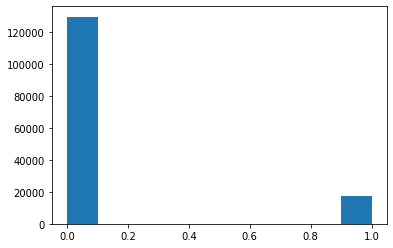

In [187]:
plt.hist(df.loc[df['group']=='treatment', 'converted']);

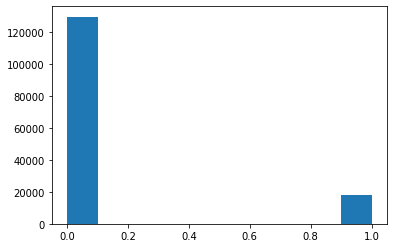

In [188]:
plt.hist(df.loc[df['group']=='control', 'converted']);

In [189]:
a = df.loc[df['group']=='control', 'converted'].values
b = df.loc[df['group']=='treatment', 'converted'].values

In [190]:
from sklearn.utils import resample
# функция, создающая бутстрапированную выборку

a_means = []
b_means = []

#Делаем 10000 бутстрапированных выборок

for i in range(10000):
    a_boot = resample(a, replace=True, n_samples=len(a))
    b_boot = resample(b, replace=True, n_samples=len(b))
    
    a_means.append(a_boot.mean())
    b_means.append(b_boot.mean())
    
a_means = np.array(a_means)
b_means = np.array(b_means)

In [191]:
len(a_means)

10000

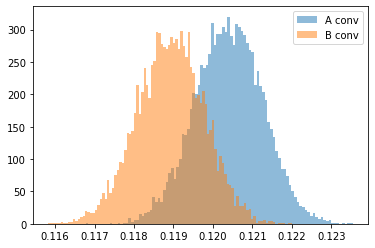

In [192]:
plt.hist(a_means, label='A conv', alpha=0.5, bins=100)
plt.hist(b_means, label='B conv', alpha=0.5, bins=100)

plt.legend()
plt.show()

In [193]:
# доверительный интервал
np.percentile(a_means, 2.5), np.percentile(a_means, 97.5)

(0.11871441964103749, 0.12205014198176654)

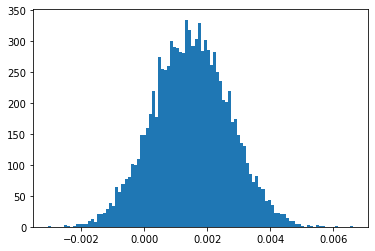

In [194]:
plt.hist(a_means - b_means, bins=100)
plt.show()

In [195]:
# сделаем оценку на p_value
dff = a_means - b_means

len(dff[dff>=0])/len(dff)

0.8888

**Вывод:** подтвердился предыдущий вывод, конверсия с новой версией сайта стала ниже.

### Проведем аналогичное исследование для СРЕДНЕГО ЧЕКА

In [196]:
df['revenue'].unique()

array([  0, 100, 250])

**Сформулируем гипотезы:**  
**H0 - нулевая гипотеза** - средний чек при новой версии сайтане превышает (не изменился или стал ниже)средний чек при старой версии сайта  
**H1 - альтернативная гипотеза** - средний чек стал выше при новой версии сайта, по сравнению со старой

In [197]:
# средний чек для группы А
df[df['group'] == 'control']['revenue'].mean()

87.43189630575671

In [198]:
#Средний чек для группы В
df[df['group'] == 'treatment']['revenue'].mean()

116.49623835519705

In [199]:
# Произведем аналогичное исследование с помощью bootstrap
a = df.loc[df['group']=='control', 'revenue'].values
b = df.loc[df['group']=='treatment', 'revenue'].values

a_rev_means = []
b_rev_means = []

#Делаем 10000 бутстрапированных выборок

for i in range(5000):
    a_rev_boot = resample(a, replace=True, n_samples=len(a))
    b_rev_boot = resample(b, replace=True, n_samples=len(b))
    
    a_rev_means.append(a_rev_boot.mean())
    b_rev_means.append(b_rev_boot.mean())
    
a_rev_means = np.array(a_rev_means)
b_rev_means = np.array(b_rev_means)

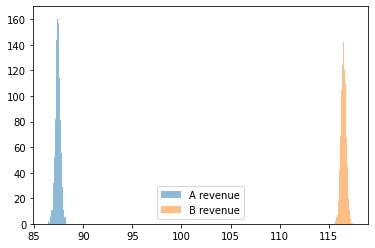

In [200]:
plt.hist(a_rev_means, label='A revenue', alpha=0.5, bins=100)
plt.hist(b_rev_means, label='B revenue', alpha=0.5, bins=100)

plt.legend()
plt.show()

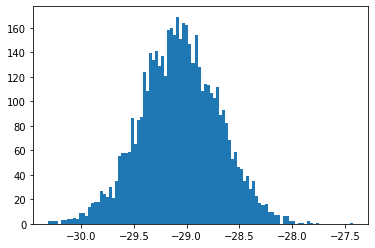

In [201]:
plt.hist(a_rev_means - b_rev_means, bins=100)
plt.show()

По значениям и визуализации очевидно, что изменения в величине среднего чека существенны. Проверим статистическую значимость на статистических криетриях при уровне значимости alpha = 0.05

In [202]:
t_score, p_value, _ = statsmodels.stats.weightstats.ttest_ind(df.query("group == 'treatment'")['revenue'],
                                                              df.query("group == 'control'")['revenue'],
                                                              alternative="larger",
                                                              usevar='unequal')
print("T-статистика={},  p_value={}".format(t_score, p_value))

T-статистика=76.8776779597559,  p_value=0.0


In [203]:
w_score, p_value = scipy.stats.mannwhitneyu(df.query("group == 'treatment'")['revenue'], 
                         df.query("group == 'control'")['revenue'],
                         alternative="greater")
print("W-статистика={},  p_value={}".format(w_score, p_value))

W-статистика=12643398633.5,  p_value=0.0


**Вывод:** Значения p value = 0, что ниже уровня значимости. Это означает , что мы не имеем оснований принять нулевую гипотезу и принимаем альтернативную, то есть что средний чек у клиентов, посетивших новую версию сайта выше, нежели у тех, кто посетил старую версию сайта.

#### Проверим значение ОБЩЕЙ СУММЫ ЧЕКА

In [204]:
# средний чек для группы А
A_rev_total = sum(df[df['group'] == 'control']['revenue'])
A_rev_total

12870150

In [205]:
# средний чек для группы B
B_rev_total = sum(df[df['group'] == 'treatment']['revenue'])
B_rev_total

17157100

In [206]:
delta = B_rev_total - A_rev_total
print(f'Общая сумма покупок группы B превышает сумму группы A на {delta} ден ед')

Общая сумма покупок группы B превышает сумму группы A на 4286950 ден ед


**Вывод:** несмотря на то , что конверсия с новой версией сайта снизилась, общая и средняя стоимости покупок оказались выше у группы Б. 

#### Проверим значение ОБЩЕГО КОЛИЧЕСТВА НЕНУЛЕВЫХ ПОКУПОК

In [279]:
# Количество покупок группы А
df[df['group'] == 'control']['revenue'].value_counts()

0      73801
250    36867
100    36534
Name: revenue, dtype: int64

In [281]:
# Количество покупок группы B
df[df['group'] == 'treatment']['revenue'].value_counts()

0      49199
100    49081
250    48996
Name: revenue, dtype: int64

In [283]:
A_total_purchases = sum(df[df['group'] == 'control']['revenue'].value_counts()[1:])
B_total_purchases = sum(df[df['group'] == 'treatment']['revenue'].value_counts()[1:])
print(f'Количество ненулевых покупок в группе А: {A_total_purchases}, \nКоличество ненулевых покупок в группе B: {B_total_purchases}')

Количество ненулевых покупок в группе А: 73401, 
Количество ненулевых покупок в группе B: 98077


**Общий вывод:** несмотря на снижение конверсии с новой версией сайта, увеличились количество и сумма покупок.   
Принять или отказаться от новой версии сайта - решение за менеджерами. Кликов меньше, а финансовый результат выше.